# Loteca

In [1]:
import keras
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


### Ler arquivo

In [2]:
df = np.load('arquivo.npy')

In [3]:
# Define o ganhador H = casa, A = Vizitante, D = empate
for i in range(len(df)):
    df[i,8] = 'H' if (int(df[i,2]) - int(df[i,6])) > 0 else 'A' if (int(df[i,2]) - int(df[i,6])) < 0 else 'D'

In [4]:
# Cria um data frame para receber os valores
df_ = pd.DataFrame(df,columns=['Concurso','Jogo','HG','Home','S','Away','AG','Dia','Res'])

In [5]:
# Transforma as colunas de gols em inteiros
df_ = df_.astype({"HG": int, "AG": int})

In [6]:
df_.head()

,Concurso,Jogo,HG,Home,S,Away,AG,Dia,Res
0,Concurso 1 (18/02/2002),1,2,FLAMENGO/RJ,,S. PAULO/SP,4,Domingo,A
1,Concurso 1 (18/02/2002),2,3,VASCO/RJ,,AMERICANO/RJ,0,Domingo,H
2,Concurso 1 (18/02/2002),3,2,SANTOS/SP,,SÃO CAETANO/SP,1,Domingo,H
3,Concurso 1 (18/02/2002),4,1,P. DESPORTOS/SP,,CORINTHIANS/SP,4,Domingo,A
4,Concurso 1 (18/02/2002),5,7,CRUZEIRO/MG,,AMÉRICA/MG,0,Sábado,H


### Frequencia de vitórias em casa (H), empates (D) e visitantes (A)

<BarContainer object of 3 artists>

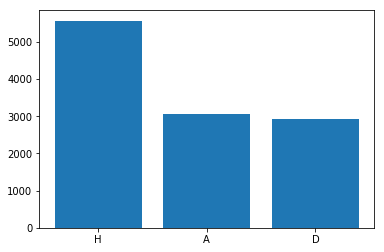

In [7]:
plt.bar(df_['Res'].value_counts().keys(),df_['Res'].value_counts())

### Média de gols dos últimos jogos

In [8]:
# Calcula a soma de gols feitos das ultimas n (window) partidas
def get_rolling_mean(dataFrame, equip, pos, window, HG_AG):   
    HA = 'Home' if HG_AG == 'HG' else 'Away' if HG_AG == 'AG' else ''
    s = dataFrame[-pos-window:-window][dataFrame[HA] == equip][HG_AG].mean()
    return s if not(np.isnan(s)) else 0

# Calcula a soma de gols recebidos das ultimas n (window) partidas
def get_rolling_received(dataFrame, equip, pos, window, HG_AG):   
    HA = 'Home' if HG_AG == 'HG' else 'Away' if HG_AG == 'AG' else ''
    HG_AG_ = 'HG' if HG_AG == 'AG' else 'AG' if HG_AG == 'HG' else ''
    s = dataFrame[-pos-window:-window][dataFrame[HA] == equip][HG_AG_].mean()
    return s if not(np.isnan(s)) else 0

    

### Nomes dos times

In [9]:
# Cria uma lista de nomes dos times
vocab = np.unique(np.concatenate((np.array(df_['Home'].unique()), np.array(df_['Away'].unique()))))

In [10]:
# Cria o indice de times
word2idx = {word: i for i, word in enumerate(vocab)}

In [11]:
# Retorna o indice de um time:
def word2vector(word):
    m = np.zeros(len(word2idx))
    idx = word2idx.get(word)
    if idx == '':
        raise ValueError('Time não encontrado no indice: ' + word)

    m[word2idx.get(word)] = 1
    return m.tolist()

In [12]:
# Transforma os dois times em um vetor com o flag do time correspondente e a média de gols
def prepare(H,A,pos):
    
    vector = []
    
    for x in word2vector(H):
        if math.isnan(x):
            raise ValueError('Time não encontrado no indice: ' + H)

        vector.append(x)
        
    for x in word2vector(A):
        if math.isnan(x):
            raise ValueError('Time não encontrado no indice: ' + A)
            
        vector.append(x)
        

#     Cálculo das médias de gols
#     vector.append(get_rolling_mean(df_, H, pos, 10, 'HG'))
#     vector.append(get_rolling_mean(df_, A, pos, 10, 'AG'))
    
#     vector.append(get_rolling_received(df_, H, pos, 10, 'HG'))
#     vector.append(get_rolling_received(df_, A, pos, 10, 'AG'))

    

    return vector

### Indexar os resultados

In [13]:
X = []
y = []

for ind_, row in df_.iterrows():
    X.append(prepare(row['Home'], row['Away'], ind_))        
    
    ry = [1,0,0] if int(row['HG']) > int(row['AG']) else \
    [0,1,0] if int(row['HG']) == int(row['AG']) else \
    [0,0,1] if int(row['HG']) < int(row['AG']) else [0,0,0]

    y.append(ry)

y = np.array(y).reshape(np.array(y).shape[0],3)

X = np.array(X)

# Normalizar gols
# X[:,-4:-3] = X[:,-4:-3]/X[:,-4:-3].max()
# X[:,-3:-2] = X[:,-3:-2]/X[:,-3:-2].max()
# X[:,-2:-1] = X[:,-2:-1]/X[:,-2:-1].max()
# X[:,-1:] = X[:,-1:]/X[:,-1:].max()



In [14]:
# X[-100:,-4:]

### Modelo

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout

model = Sequential()
model.add(Dense(124, input_shape=(np.array(X).shape[1],), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(62, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(62, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Flatten())
model.add(Dense(3))
model.add(Activation('sigmoid'))

In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


### Separar os datasets de treinamento e teste

In [17]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)

In [18]:
X_train, y_train, X_test, y_test = X[:-int(X.shape[0]/20)], y[:-int(y.shape[0]/20)], X[-int(X.shape[0]/20):], y[-int(y.shape[0]/20):],

### Treinar o modelo

In [19]:
model.fit(X_train, y_train, epochs=500, batch_size=500)

Epoch 1/500
10982/10982 [==============================] - 2s 173us/step - loss: 0.6751 - acc: 0.6437
Epoch 2/500
10982/10982 [==============================] - 1s 105us/step - loss: 0.6247 - acc: 0.6681
Epoch 3/500
10982/10982 [==============================] - 1s 104us/step - loss: 0.6107 - acc: 0.6662
Epoch 4/500
10982/10982 [==============================] - 1s 107us/step - loss: 0.6027 - acc: 0.6802
Epoch 5/500
10982/10982 [==============================] - 1s 110us/step - loss: 0.5955 - acc: 0.6974
Epoch 6/500
10982/10982 [==============================] - 1s 102us/step - loss: 0.5861 - acc: 0.7055
Epoch 7/500
10982/10982 [==============================] - 1s 108us/step - loss: 0.5760 - acc: 0.7102
Epoch 8/500
10982/10982 [==============================] - 1s 104us/step - loss: 0.5674 - acc: 0.7133
Epoch 9/500
10982/10982 [==============================] - 1s 103us/step - loss: 0.5601 - acc: 0.7180
Epoch 10/500
10982/10982 [==============================] - 1s 108us/step - loss: 

10982/10982 [==============================] - 1s 102us/step - loss: 0.3896 - acc: 0.7990
Epoch 79/500
10982/10982 [==============================] - 1s 103us/step - loss: 0.3899 - acc: 0.7992
Epoch 80/500
10982/10982 [==============================] - 1s 101us/step - loss: 0.3921 - acc: 0.7970
Epoch 81/500
10982/10982 [==============================] - 1s 103us/step - loss: 0.3920 - acc: 0.7955
Epoch 82/500
10982/10982 [==============================] - 1s 104us/step - loss: 0.3909 - acc: 0.7969
Epoch 83/500
10982/10982 [==============================] - 1s 100us/step - loss: 0.3890 - acc: 0.7986
Epoch 84/500
10982/10982 [==============================] - 1s 103us/step - loss: 0.3902 - acc: 0.7975
Epoch 85/500
10982/10982 [==============================] - 1s 104us/step - loss: 0.3881 - acc: 0.7984 0s - loss: 0.3838 - acc:
Epoch 86/500
10982/10982 [==============================] - 1s 103us/step - loss: 0.3921 - acc: 0.7962
Epoch 87/500
10982/10982 [==============================] - 1

10982/10982 [==============================] - 1s 101us/step - loss: 0.3737 - acc: 0.8047
Epoch 155/500
10982/10982 [==============================] - 1s 101us/step - loss: 0.3724 - acc: 0.8043
Epoch 156/500
10982/10982 [==============================] - 1s 109us/step - loss: 0.3768 - acc: 0.8008
Epoch 157/500
10982/10982 [==============================] - 1s 109us/step - loss: 0.3743 - acc: 0.8029
Epoch 158/500
10982/10982 [==============================] - 1s 109us/step - loss: 0.3749 - acc: 0.8025
Epoch 159/500
10982/10982 [==============================] - 1s 108us/step - loss: 0.3769 - acc: 0.8000
Epoch 160/500
10982/10982 [==============================] - 1s 110us/step - loss: 0.3737 - acc: 0.8027
Epoch 161/500
10982/10982 [==============================] - 1s 107us/step - loss: 0.3756 - acc: 0.8022
Epoch 162/500
10982/10982 [==============================] - 1s 105us/step - loss: 0.3736 - acc: 0.8013
Epoch 163/500
10982/10982 [==============================] - 1s 105us/step - l

10982/10982 [==============================] - 1s 106us/step - loss: 0.3706 - acc: 0.8019
Epoch 232/500
10982/10982 [==============================] - 1s 105us/step - loss: 0.3679 - acc: 0.8046
Epoch 233/500
10982/10982 [==============================] - 1s 105us/step - loss: 0.3692 - acc: 0.8035
Epoch 234/500
10982/10982 [==============================] - 1s 107us/step - loss: 0.3684 - acc: 0.8050
Epoch 235/500
10982/10982 [==============================] - 1s 111us/step - loss: 0.3687 - acc: 0.8044
Epoch 236/500
10982/10982 [==============================] - 1s 115us/step - loss: 0.3697 - acc: 0.8014 0s - loss: 0.376
Epoch 237/500
10982/10982 [==============================] - 1s 109us/step - loss: 0.3682 - acc: 0.8037
Epoch 238/500
10982/10982 [==============================] - 1s 112us/step - loss: 0.3673 - acc: 0.8041
Epoch 239/500
10982/10982 [==============================] - 1s 111us/step - loss: 0.3667 - acc: 0.8054
Epoch 240/500
10982/10982 [==============================] - 

10982/10982 [==============================] - 1s 107us/step - loss: 0.3648 - acc: 0.8072 1s - loss: 0.34
Epoch 309/500
10982/10982 [==============================] - 1s 103us/step - loss: 0.3643 - acc: 0.8062
Epoch 310/500
10982/10982 [==============================] - 1s 102us/step - loss: 0.3670 - acc: 0.8041
Epoch 311/500
10982/10982 [==============================] - 1s 106us/step - loss: 0.3650 - acc: 0.8052
Epoch 312/500
10982/10982 [==============================] - 1s 103us/step - loss: 0.3631 - acc: 0.8051
Epoch 313/500
10982/10982 [==============================] - 1s 101us/step - loss: 0.3654 - acc: 0.8042
Epoch 314/500
10982/10982 [==============================] - 1s 103us/step - loss: 0.3654 - acc: 0.8052
Epoch 315/500
10982/10982 [==============================] - 1s 108us/step - loss: 0.3641 - acc: 0.8050
Epoch 316/500
10982/10982 [==============================] - 1s 104us/step - loss: 0.3647 - acc: 0.8073
Epoch 317/500
10982/10982 [==============================] - 1

10982/10982 [==============================] - 1s 102us/step - loss: 0.3627 - acc: 0.8066
Epoch 386/500
10982/10982 [==============================] - 1s 100us/step - loss: 0.3626 - acc: 0.8043
Epoch 387/500
10982/10982 [==============================] - 1s 101us/step - loss: 0.3634 - acc: 0.8069
Epoch 388/500
10982/10982 [==============================] - 1s 108us/step - loss: 0.3646 - acc: 0.8061
Epoch 389/500
10982/10982 [==============================] - 1s 108us/step - loss: 0.3633 - acc: 0.8062
Epoch 390/500
10982/10982 [==============================] - 1s 108us/step - loss: 0.3621 - acc: 0.8056
Epoch 391/500
10982/10982 [==============================] - 1s 101us/step - loss: 0.3598 - acc: 0.8092
Epoch 392/500
10982/10982 [==============================] - 1s 102us/step - loss: 0.3629 - acc: 0.8067
Epoch 393/500
10982/10982 [==============================] - 1s 99us/step - loss: 0.3607 - acc: 0.8082
Epoch 394/500
10982/10982 [==============================] - 1s 100us/step - lo

10982/10982 [==============================] - 1s 102us/step - loss: 0.3627 - acc: 0.8073
Epoch 462/500
10982/10982 [==============================] - 1s 111us/step - loss: 0.3626 - acc: 0.8058
Epoch 463/500
10982/10982 [==============================] - 1s 114us/step - loss: 0.3614 - acc: 0.8051
Epoch 464/500
10982/10982 [==============================] - 1s 116us/step - loss: 0.3618 - acc: 0.8086
Epoch 465/500
10982/10982 [==============================] - 1s 102us/step - loss: 0.3597 - acc: 0.8077
Epoch 466/500
10982/10982 [==============================] - 1s 101us/step - loss: 0.3619 - acc: 0.8043
Epoch 467/500
10982/10982 [==============================] - 1s 105us/step - loss: 0.3610 - acc: 0.8079
Epoch 468/500
10982/10982 [==============================] - 1s 104us/step - loss: 0.3599 - acc: 0.8078
Epoch 469/500
10982/10982 [==============================] - 1s 102us/step - loss: 0.3624 - acc: 0.8070
Epoch 470/500
10982/10982 [==============================] - 1s 111us/step - l

In [20]:
model.evaluate(X_test, y_test, verbose=1)

578/578 [==============================] - 0s 272us/step


[1.996968688024369, 0.6447520283885481]

### Avaliar precisão

In [21]:
# Cria as colunas com os resultados reais e as apostas
def aposta(dr,p):
    dr['RC1'] = 'X' if dr['HG'] > dr['AG'] else ''
    dr['RCM'] = 'X' if dr['HG'] == dr['AG'] else ''
    dr['RC2'] = 'X' if dr['HG'] < dr['AG'] else ''
    
    
#     Criar apostas com jogos simples, duplos e triplos:
    c=0
    if p[0,0] > p.mean():
        dr['AC1'] = 'X' 
        c += 1
    else:
        dr['AC1'] = ''
    

    if p[0,1] > p.mean():
        dr['ACM'] = 'X' 
        c += 1
    else:
        dr['ACM'] = ''

    if p[0,2] > p.mean():
        dr['AC2'] = 'X' 
        c += 1
    else:
        dr['AC2'] = ''
        
#         Criar marcador de jogos duplos e triplos
    if c==2:
        dr['D']='D'
    else:
        dr['D']=''
    if c==3:
        dr['T']='T'
    else:
        dr['T']=''
        

    return dr
    
    
    

In [22]:
dfx = df_[int(-df_.shape[0]/20):]

ds = []

X_ = X[-int(X.shape[0]/20):]

prec = []

i=0
for idx, dfr in dfx.iterrows():
    
    pa = prepare(dfr['Home'], dfr['Away'],idx)

    p = model.predict(np.array(pa).reshape(1,len(pa)))
    
    i += 1
    
#     Quantificar a previsão e comparar com o real
    px = 'H' if p[0,0] > p.mean() else 'A' if p[0,2] > p.mean() else 'D' if p[0,1] > p.mean() else ''
    
    prec.append(1 if px == dfr['Res'] else 0)
    
    dfr['S'] = px
    
#     Cria um dataframe com os resultados para report
    ds.append(aposta(dfr,p))
    
dfs = pd.DataFrame(ds)

print(round((abs(np.mean(prec))) * 100,0), '%')
    

43.0 %


In [30]:
dfs[dfs['Concurso']=='Concurso 825 (05/11/2018)']

,Concurso,Jogo,HG,Home,S,Away,AG,Dia,Res,RC1,RCM,RC2,AC1,ACM,AC2,D,T
11532,Concurso 825 (05/11/2018),1,0,FLUMINENSE/RJ,A,VASCO DA GAMA/RJ,1,Sábado,A,,,X,,X,X,D,
11533,Concurso 825 (05/11/2018),2,3,PALMEIRAS/SP,H,SANTOS/SP,2,Sábado,H,X,,,X,,,,
11534,Concurso 825 (05/11/2018),3,2,SÃO PAULO/SP,H,FLAMENGO/RJ,2,Domingo,D,,X,,X,,,,
11535,Concurso 825 (05/11/2018),4,1,AVAÍ/SC,H,LONDRINA/PR,1,Sábado,D,,X,,X,,,,
11536,Concurso 825 (05/11/2018),5,1,ATLÉTICO/GO,H,FORTALEZA/CE,2,Sábado,A,,,X,X,,,,
11537,Concurso 825 (05/11/2018),6,2,CRB/AL,H,BOA ESPORTE/MG,1,Sábado,H,X,,,X,,,,
11538,Concurso 825 (05/11/2018),7,0,CORITIBA/PR,H,GUARANI/SP,2,Sábado,A,,,X,X,X,,D,
11539,Concurso 825 (05/11/2018),8,0,ATLÉTICO/MG,H,GRÊMIO/RS,1,Sábado,A,,,X,X,,,,
11540,Concurso 825 (05/11/2018),9,1,AMÉRICA/MG,A,CRUZEIRO/MG,2,Domingo,A,,,X,,X,X,D,
11541,Concurso 825 (05/11/2018),10,1,BOTAFOGO/RJ,H,CORINTHIANS/SP,0,Domingo,H,X,,,X,X,,D,


In [24]:
dfs[dfs['S']==dfs['Res']].groupby(['Concurso'])['Concurso'].value_counts()

Concurso                   Concurso                 
Concurso 785 (05/02/2018)  Concurso 785 (05/02/2018)    1
Concurso 786 (14/02/2018)  Concurso 786 (14/02/2018)    4
Concurso 787 (20/02/2018)  Concurso 787 (20/02/2018)    4
Concurso 788 (26/02/2018)  Concurso 788 (26/02/2018)    7
Concurso 789 (05/03/2018)  Concurso 789 (05/03/2018)    5
Concurso 790 (12/03/2018)  Concurso 790 (12/03/2018)    6
Concurso 791 (19/03/2018)  Concurso 791 (19/03/2018)    7
Concurso 792 (26/03/2018)  Concurso 792 (26/03/2018)    5
Concurso 793 (02/04/2018)  Concurso 793 (02/04/2018)    6
Concurso 794 (09/04/2018)  Concurso 794 (09/04/2018)    9
Concurso 795 (16/04/2018)  Concurso 795 (16/04/2018)    9
Concurso 796 (23/04/2018)  Concurso 796 (23/04/2018)    6
Concurso 797 (30/04/2018)  Concurso 797 (30/04/2018)    5
Concurso 798 (07/05/2018)  Concurso 798 (07/05/2018)    6
Concurso 799 (14/05/2018)  Concurso 799 (14/05/2018)    8
Concurso 800 (21/05/2018)  Concurso 800 (21/05/2018)    4
Concurso 801 (28/05

In [25]:
# Considera os duplos e triplos
# RC1	RCM	RC2	AC1	ACM	AC2
dfs[((dfs['RC1']==dfs['AC1'])&(dfs['RC1']=='X')) | ((dfs['RC2']==dfs['AC2'])&(dfs['RC2']=='X')) | ((dfs['RCM']==dfs['ACM'])&(dfs['RCM']=='X'))].groupby(['Concurso'])['Concurso'].value_counts()

Concurso                   Concurso                 
Concurso 785 (05/02/2018)  Concurso 785 (05/02/2018)     1
Concurso 786 (14/02/2018)  Concurso 786 (14/02/2018)     5
Concurso 787 (20/02/2018)  Concurso 787 (20/02/2018)     5
Concurso 788 (26/02/2018)  Concurso 788 (26/02/2018)     8
Concurso 789 (05/03/2018)  Concurso 789 (05/03/2018)     5
Concurso 790 (12/03/2018)  Concurso 790 (12/03/2018)     8
Concurso 791 (19/03/2018)  Concurso 791 (19/03/2018)     7
Concurso 792 (26/03/2018)  Concurso 792 (26/03/2018)     5
Concurso 793 (02/04/2018)  Concurso 793 (02/04/2018)     8
Concurso 794 (09/04/2018)  Concurso 794 (09/04/2018)    10
Concurso 795 (16/04/2018)  Concurso 795 (16/04/2018)     9
Concurso 796 (23/04/2018)  Concurso 796 (23/04/2018)     8
Concurso 797 (30/04/2018)  Concurso 797 (30/04/2018)     5
Concurso 798 (07/05/2018)  Concurso 798 (07/05/2018)     7
Concurso 799 (14/05/2018)  Concurso 799 (14/05/2018)     9
Concurso 800 (21/05/2018)  Concurso 800 (21/05/2018)     6
Con

In [26]:
# Preço das apostas
2**dfs[dfs['D']=='D'].groupby(['Concurso'])['Concurso'].value_counts()

Concurso                   Concurso                 
Concurso 786 (14/02/2018)  Concurso 786 (14/02/2018)       2
Concurso 787 (20/02/2018)  Concurso 787 (20/02/2018)      32
Concurso 788 (26/02/2018)  Concurso 788 (26/02/2018)       8
Concurso 789 (05/03/2018)  Concurso 789 (05/03/2018)       4
Concurso 790 (12/03/2018)  Concurso 790 (12/03/2018)      64
Concurso 791 (19/03/2018)  Concurso 791 (19/03/2018)       8
Concurso 792 (26/03/2018)  Concurso 792 (26/03/2018)       2
Concurso 793 (02/04/2018)  Concurso 793 (02/04/2018)      32
Concurso 794 (09/04/2018)  Concurso 794 (09/04/2018)      64
Concurso 795 (16/04/2018)  Concurso 795 (16/04/2018)      64
Concurso 796 (23/04/2018)  Concurso 796 (23/04/2018)     128
Concurso 797 (30/04/2018)  Concurso 797 (30/04/2018)       4
Concurso 798 (07/05/2018)  Concurso 798 (07/05/2018)      16
Concurso 799 (14/05/2018)  Concurso 799 (14/05/2018)       8
Concurso 800 (21/05/2018)  Concurso 800 (21/05/2018)      32
Concurso 801 (28/05/2018)  Concu

### Lista de times

In [ ]:
vocab

### Realizar previsão

In [27]:
H = 'LIVERPOOL/ING'
A = 'TOTTENHAM/ING'

prep = [prepare(H,A,1)]
    
prepx = np.array(prep).reshape(np.array(prep).shape[0],np.array(prep).shape[1])
    
p = model.predict(prepx)


print(p)


[[0.21188366 0.01429426 0.48967227]]


In [ ]:
p[0,2]

In [ ]:
p.mean()